# TUTORIAL: Fine-Tune BERT model for sentiment analysis with AI notebooks

The aim is to fine-tune a **BERT** model for sentiment analysis on e-commerce site reviews.

![](./assets/sentiment-analysis-bert.png)

- **What is a BERT model?**

`BERT` (Bidirectional Encoder Representations from Transformers) is a model that represents an encoder block of a transformer. It is pre-trained with a huge corpus of unlabeled text. The power of BERT is that the same pre-trained model can be used, simply by adding an additional output layer, in a variety of tasks like sentiment analysis

### Code:
- Install dependencies
- Import Python librairies
- Check GPU availability
- Load dataset from Hugging Face hub
- EDA
- Data Cleaning
- Select relevant features
- Feature Engineering
- Fine-Tune BERT model for sentiment analysis
- Test the trained model

## Step 1 - Install dependencies

In [ ]:
!pip install datasets scikit-learn nltk transformers matplotlib torch

## Step 2 - Import Python librairies

In [2]:
# basic python librairies
import re
import os
import json
import string
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data loading
from datasets import load_dataset

# eda and data processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# bert fine-tuning
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# metrics evaluation
from sklearn.metrics import f1_score

# device setting and data loaders 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

## Step 3 - Check GPU availability

In [3]:
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 4 - Load dataset from Hugging Face hub

In [4]:
# load the dataset of womens clothing e-commerce reviews 
dataset_reviews = load_dataset("saattrupdan/womens-clothing-ecommerce-reviews")

In [5]:
# define training, validation and test sets
df_train = pd.DataFrame(dataset_reviews['train'])
df_val = pd.DataFrame(dataset_reviews['val'])
df_test = pd.DataFrame(dataset_reviews['test'])

## Step 5 - EDA

- **Check dataset balance**

Text(0.5, 1.0, 'Classes distribution (from 1 to 5 stars)')

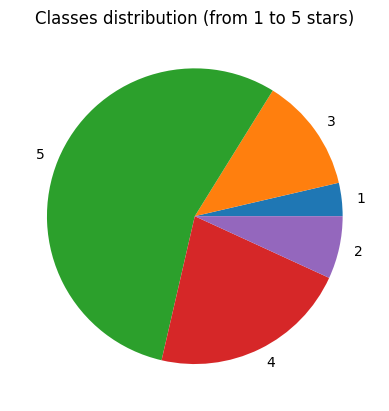

In [7]:
# display the rating repartition
labels_occurence = Counter(dataset_reviews['train']['rating'])
plt.pie(labels_occurence.values(), labels=labels_occurence)
plt.title("Classes distribution (from 1 to 5 stars)")

Text(0.5, 1.0, 'Product reviews distribution')

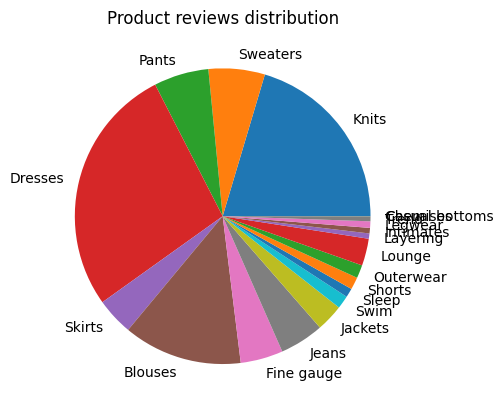

In [8]:
# display the products repartition
product_occurence = Counter(dataset_reviews['train']['class_name'])
plt.pie(product_occurence.values(), labels=product_occurence)
plt.title("Product reviews distribution")

- **Estimate review length**

In [9]:
# review length
lens = [len(i.split()) for i in dataset_reviews['train']['review_text']]

Text(0, 0.5, 'Count')

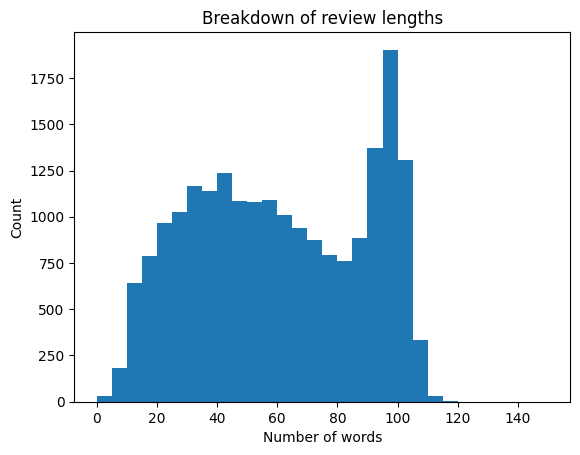

In [10]:
# display histogramm
plt.hist(lens, bins=30, range=[0, 150])
plt.title("Breakdown of review lengths")
plt.xlabel("Number of words")
plt.ylabel("Count")

- **Calculate word frequency**

In [11]:
# CountVectorizer object
vectorizer = CountVectorizer()

# fit_transform() method
Xtrain = vectorizer.fit_transform(dataset_reviews['train']['review_text'])

# list of terms 
words = vectorizer.get_feature_names_out()

In [12]:
# number of terms 
print("Number of different terms in dictionary:", len(vectorizer.get_feature_names_out()))

Number of different terms in dictionary: 13594


With the resulting matrix, calculate the frequency of the terms by summing each row of the matrix.

`frequency of term 1 = sum(row 1)`

...

`frequency of term n = sum(row n)`

In [13]:
# display terms frequence
Xtrain = Xtrain.toarray()
freq = np.sum(Xtrain, axis=0)

In [14]:
# transform words into a dataframe
df_words = pd.DataFrame(words)

# transform frequences into a dataframe
df_freq = pd.DataFrame(freq)

# create the term-frequence dataframe
df_term_freq = pd.concat([df_words, df_freq], axis=1)
df_term_freq.columns = ['term', 'frequence']

In [15]:
# create list for frequences > 1
freq_sup_one = []
term = []

# create a filter to save only frequences > 1
for i in range(len(df_term_freq)): 
    if df_term_freq['frequence'][i]>1:
        freq_sup_one.append(df_term_freq['frequence'][i])
        term.append(df_term_freq['term'][i])

# transform lists into a dataframe
df_freq_sup_one = pd.DataFrame(freq_sup_one)
df_term = pd.DataFrame(term)

df_term_frequent = pd.concat([df_term, df_freq_sup_one], axis=1)

## Step 6 - Data Cleaning

Remove stop words, url, emojis, low term frequencies...

- **Clean the reviews**

In [16]:
# define data cleaning function
def clean_text(text):
    
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    # Analyzing the most used words below, i chose to exclude these because there are too many and are unnecessary
    text = re.sub('book|one', '', text)
    # Convert to lower case
    text = text.lower()
    # remove scores
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# apply the function
df_train['review_text'] = df_train['review_text'].apply(clean_text)
df_val['review_text'] = df_val['review_text'].apply(clean_text)
df_test['review_text'] = df_test['review_text'].apply(clean_text)

- **Remove stop words**

In [17]:
# download stopwords list
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /workspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /workspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# define remove stopwords function
def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(texto.lower())
    return " ".join([token for token in tokens if token not in stop_words])

# apply the function
df_train['review_text'] = df_train['review_text'].apply(remove_stopwords)
df_val['review_text'] = df_val['review_text'].apply(remove_stopwords)
df_test['review_text'] = df_test['review_text'].apply(remove_stopwords)

- **Normalize text**

In [19]:
# define text normalization function
def normalize_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text)
    
# apply the function
df_train['review_text'] = df_train['review_text'].apply(normalize_text)
df_val['review_text'] = df_val['review_text'].apply(normalize_text)
df_test['review_text'] = df_test['review_text'].apply(normalize_text)

## Step 7 - Select relevant features

- **Remove the correlated and non pertinent data**

In [20]:
# training data
df_train = df_train.drop(['age', 'positive_feedback_count', 'division_name', 'department_name', 'class_name', 'recommended_ind'], axis=1)
df_train

,review_text,rating
0,love shirt first time wash shrunk much becam u...,1
1,sweater unflatt boxi fall like model soft fabr...,3
2,fell love bottom first site littl worri would ...,5
3,love dress purchas dress wear hymoon pari made...,5
4,fell love dress saw onlin got soon went sale c...,5
...,...,...
20636,realli like jean initi end day waist realli ba...,3
20637,top soo pretti cool edgeit look feel like real...,5
20638,absolut love top im alway either xsmall mauv t...,5
20639,tts bought usual pilcro size enjoy fit better ...,4


In [21]:
# validation data
df_val = df_val.drop(['age', 'positive_feedback_count', 'division_name', 'department_name', 'class_name', 'recommended_ind'], axis=1)
df_val

,review_text,rating
0,shed cloth someth fierc much dont want return ...,4
1,bought dress wear lowkey backyard rehears dinn...,3
2,soft fit without tight flatter necklin nice em...,5
3,came across store immedi fell love onlin photo...,5
4,saw store got green differ typic xs dress some...,4
...,...,...
995,dress beauti uniqu cutout lace realli stand ho...,2
996,great jacket love hoodi insert remov wear oute...,5
997,bought green motif color beauti look like pict...,4
998,fell love dress soon came across onlin order d...,4


In [22]:
# test data
df_test = df_test.drop(['age', 'positive_feedback_count', 'division_name', 'department_name', 'class_name', 'recommended_ind'], axis=1)
df_test

,review_text,rating
0,im usual size l retail tri button bottom excit...,3
1,order blue top great hot summer southeast year,4
2,seem pretti shapeless surpris design perhap bi...,1
3,saw store immedi love even tri style classic f...,5
4,immedi drawn dress saw store im normal size fe...,4
...,...,...
995,dress beauti pretti look pictur prettier great...,5
996,im pleas purchas dress perfect danc springsumm...,5
997,hourglass figur dress accentu curv need wear t...,5
998,cute waffl tshirt materi thin seethrough cute ...,4


## Step 8 - Feature Engineering

- **Encode labels**

In [23]:
# y_train before encoding
df_train['rating'].values

array([1, 3, 5, ..., 5, 4, 5])

In [24]:
# encode 1,2,3,4,5 -> 0,1,2,3,4
encoder = LabelEncoder()

# training data
X_train = df_train['review_text']
y_train = encoder.fit_transform(df_train['rating'])
 
# validation data
X_val = df_val['review_text']
y_val = encoder.transform(df_val['rating'])
    
# test data
X_test = df_test['review_text']
y_test = encoder.transform(df_test['rating'])

In [25]:
# y_train encoded
y_train

array([0, 2, 4, ..., 4, 3, 4])

## Step 9 - Fine-Tune BERT model for sentiment analysis

- **Define the max length**

In [26]:
# set it to 120
pad_len=120

- **Load tokenizer and encode data**

In [27]:
# define bert tokenizer
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [28]:
# tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = pad_len,
                                              return_tensors='pt')
 
X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = pad_len,
                                              return_tensors='pt')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = pad_len,
                                              return_tensors='pt')

- **Transform data to Tensor**

In [29]:
# train dataset
dataset_train = TensorDataset(X_train_encoded['input_ids'], 
                              X_train_encoded['attention_mask'],
                              torch.tensor(y_train))

# val dataset
dataset_val = TensorDataset(X_val_encoded['input_ids'], 
                            X_val_encoded['attention_mask'],
                           torch.tensor(y_val))

# test dataset
dataset_test = TensorDataset(X_test_encoded['input_ids'], 
                            X_test_encoded['attention_mask'],
                           torch.tensor(y_test))

- **Load Bert model for sequence classification**

In [30]:
# load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(np.unique(y_train)),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# train model with GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


- **Create dataloaders**

In [32]:
# batch size
batch_size = 32

# training set
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

# validation set
dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=batch_size
)

- **Create a dict for the labels**

In [33]:
# key: basic rating (from 1 to 5 stars)
# value: encoded label
label_dict = {'1':0, '2':1, '3':2, '4':3, '5':4}
label_dict.items()

dict_items([('1', 0), ('2', 1), ('3', 2), ('4', 3), ('5', 4)])

- **Set up model optimizer and scheduler**

In [35]:
# optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

# number of steps
epochs = 5
total_steps = len(dataloader_train) * epochs

# scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

- **Create accuracy function**

In [36]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

- **Define model evaluation function**

In [37]:
def evaluate(dataloader):

    model.eval()

    total_loss = 0
    total_accuracy = 0

    for batch in dataloader:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        

            outputs = model(**inputs) 

            loss = outputs[0]
            logits = outputs[1]

            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            total_accuracy += flat_accuracy(logits, label_ids)

    avg_loss = total_loss / len(dataloader)       
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

- **Launch model fine-tuning on 5 epochs**

In [38]:
print("Fine Tuning of BERT model is starting...")

for epoch_i in range(0, epochs):
    
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(dataloader_train):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)

        loss = outputs[0]

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(dataloader_train)            

    training_loss, training_accuracy = evaluate(dataloader_train)
    validation_loss, validation_accuracy = evaluate(dataloader_val)

    print("")
    print("Epoch: {}/{}".format(epoch_i + 1, epochs))
    print("Training Loss: {}".format(avg_train_loss))
    print("Training Accuracy: {}".format(training_accuracy))
    print("Validation Loss: {}".format(validation_loss))
    print("Validation Accuracy: {}".format(validation_accuracy))
    print("")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy': training_accuracy,
            'Validation Loss': validation_loss,
            'Validation Accuracy': validation_accuracy
        }
    )

Fine Tuning of BERT model is starting...

Epoch: 1/5
Training Loss: 0.9787735664069468
Training Accuracy: 0.6750193498452013
Validation Loss: 0.8087834380567074
Validation Accuracy: 0.6484375


Epoch: 2/5
Training Loss: 0.8105400662188744
Training Accuracy: 0.7261029411764706
Validation Loss: 0.8035906106233597
Validation Accuracy: 0.6572265625


Epoch: 3/5
Training Loss: 0.7036994074704847
Training Accuracy: 0.7864260835913313
Validation Loss: 0.8122159857302904
Validation Accuracy: 0.658203125


Epoch: 4/5
Training Loss: 0.6027057669111081
Training Accuracy: 0.834703947368421
Validation Loss: 0.860997449606657
Validation Accuracy: 0.6416015625


Epoch: 5/5
Training Loss: 0.5268889718772641
Training Accuracy: 0.8518769349845201
Validation Loss: 0.9054699223488569
Validation Accuracy: 0.64453125



## Step 10 - Test the trained model

Now that the model is trained, test it on the **test dataset**: `X_test`,`y_test`.

In [39]:
# sentiment analysis function for BERT model on test dataset
def bert_sentiment(dataset_test, y_test):
    
    # encode dataset
    test_encoded = tokenizer.batch_encode_plus(dataset_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = pad_len,
                                              return_tensors='pt')
    
    # inputs and label
    test_seq = test_encoded['input_ids'].to(device)
    attention_mask = test_encoded['attention_mask'].to(device)
    test_y = torch.tensor(y_test)

    # get predictions for test data
    with torch.no_grad():
        preds = model(test_seq.to(device), attention_mask.to(device))
        preds = preds[0].detach().cpu().numpy()
    
    # get the labels
    pred = np.argmax(preds, axis = 1)
    
    # save it as a dataframe
    result_model_bert = pd.DataFrame(pred, columns = ['rate_bert'])
    
    return result_model_bert

In [40]:
# get sentiment analysis result
print("The BERT model starts analysis...")

# time the inference
start = time.time()

# get sentiment analysis result
bert_output = bert_sentiment(X_test, y_test)

# end of the process
end = time.time()
print(f"BERT model process time: {end - start} seconds")

The BERT model starts analysis...
BERT model process time: 1.8481903076171875 seconds


In [41]:
# save results as a json file
result_bert_json = '/workspace/results/result_model_bert.json'
bert_output.to_json(result_bert_json, orient="records")